# Correspondence of precursor emissions to ozone forcing

In AR6, we do not separate tropospheric and stratospheric ozone.

Coefficients provided by AerChemMIP models contributing to Thornhill et al. (2021a), and historical time series from Skeie et al. 2020. The forcing dependence on temperature is from Thornhill et al. (2021b)

Once this is tuned, update FaIR (may need 1.6.2 release)

- Skeie et al. 2020  https://www.nature.com/articles/s41612-020-00131-0
- Thornhill et al. 2021a  https://acp.copernicus.org/preprints/acp-2019-1205/acp-2019-1205.pdf
- Thornhill et al. 2021b  https://acp.copernicus.org/preprints/acp-2019-1207/acp-2019-1207.pdf

In [1]:
import fair
import numpy as np
import pandas as pd
import matplotlib.pyplot as pl
from fair.constants import molwt
from fair.forcing.ozone_tr import stevenson
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
import copy

from ar6.forcing.ozone import eesc
from ar6.constants.gases import rcmip_to_ghg_names

## The historcial forcing time series

Follow Skeie et al., 2020 exclusively for the historical (1850-2010)

Update 18.01.2020: 0.47 1750-2019 - the foot has come down

In [2]:
good_models = ['BCC-ESM1', 'CESM2(WACCM6)', 'GFDL-ESM4', 'GISS-E2-1-H', 'MRI-ESM2-0', 'OsloCTM3']
skeie_trop = pd.read_csv('../data_input/Skeie_et_al_npj_2020/skeie_ozone_trop.csv', index_col=0)
skeie_trop = skeie_trop.loc[good_models]
skeie_trop.insert(0, 1850, 0)
skeie_trop.columns = pd.to_numeric(skeie_trop.columns)
skeie_trop.interpolate(axis=1, method='values', limit_area='inside', inplace=True)

In [3]:
skeie_trop

,1850,1920,1930,1940,1950,1960,1970,1980,1990,2000,2007,2010,2014,2017,2020
Model,,,,,,,,,,,,,,,
BCC-ESM1,0.0,0.05020,0.06650,0.07970,0.1030,0.14860,0.2012,0.2367,0.2643,0.3086,0.3347,0.3404,NaN,NaN,NaN
CESM2(WACCM6),0.0,0.04420,0.05930,0.08410,0.1003,0.14520,0.1939,0.2350,0.2822,0.3318,0.3518,0.3711,NaN,NaN,NaN
GFDL-ESM4,0.0,0.05220,0.06250,0.08600,0.1096,0.16210,0.2113,0.2463,0.2733,0.3116,0.3280,0.3392,NaN,NaN,NaN
GISS-E2-1-H,0.0,0.04930,0.06740,0.07670,0.1137,0.14790,0.1850,0.2209,0.2684,0.3266,0.3593,0.3660,NaN,NaN,NaN
MRI-ESM2-0,0.0,0.05700,0.07230,0.08570,0.1096,0.15920,0.2159,0.2661,0.3122,0.3320,0.3397,0.3448,NaN,NaN,NaN
OsloCTM3,0.0,0.08204,0.09376,0.10548,0.1172,0.17065,0.2241,0.2777,0.3173,0.3527,0.3987,0.4047,0.4209,0.4117,0.4274


In [4]:
skeie_strat = pd.read_csv('../data_input/Skeie_et_al_npj_2020/skeie_ozone_strat.csv', index_col=0)
skeie_strat = skeie_strat.loc[good_models]
skeie_strat.insert(0, 1850, 0)
skeie_strat.columns = pd.to_numeric(skeie_strat.columns)
skeie_strat.interpolate(axis=1, method='values', limit_area='inside', inplace=True)
skeie_strat

,1850,1920,1930,1940,1950,1960,1970,1980,1990,2000,2007,2010,2014,2017,2020
Model,,,,,,,,,,,,,,,
BCC-ESM1,0.0,0.00760,0.0092,0.01430,0.0239,0.03590,0.0496,0.0367,0.0085,0.0147,0.0189,0.0207,NaN,NaN,NaN
CESM2(WACCM6),0.0,0.02020,0.0221,0.04000,0.0346,0.04460,0.0533,0.0530,0.0282,0.0468,0.0456,0.0578,NaN,NaN,NaN
GFDL-ESM4,0.0,0.01380,0.0126,0.02260,0.0315,0.03600,0.0331,0.0145,-0.0397,-0.0209,-0.0206,-0.0170,NaN,NaN,NaN
GISS-E2-1-H,0.0,0.01820,0.0122,-0.00030,0.0248,0.02330,0.0321,0.0913,0.1171,0.0737,0.0776,0.0898,NaN,NaN,NaN
MRI-ESM2-0,0.0,0.00720,0.0144,0.01230,0.0198,0.03200,0.0570,0.0668,0.0618,0.0474,0.0403,0.0411,NaN,NaN,NaN
OsloCTM3,0.0,0.02485,0.0284,0.03195,0.0355,0.04535,0.0552,0.0710,0.0819,0.0876,0.1102,0.1198,0.1318,0.1294,0.1359


In [5]:
skeie_total = skeie_trop + skeie_strat
#skeie_total.drop([2014,2017,2020], inplace=True, axis=1)
skeie_total

,1850,1920,1930,1940,1950,1960,1970,1980,1990,2000,2007,2010,2014,2017,2020
Model,,,,,,,,,,,,,,,
BCC-ESM1,0.0,0.05780,0.07570,0.09400,0.1269,0.1845,0.2508,0.2734,0.2728,0.3233,0.3536,0.3611,NaN,NaN,NaN
CESM2(WACCM6),0.0,0.06440,0.08140,0.12410,0.1349,0.1898,0.2472,0.2880,0.3104,0.3786,0.3974,0.4289,NaN,NaN,NaN
GFDL-ESM4,0.0,0.06600,0.07510,0.10860,0.1411,0.1981,0.2444,0.2608,0.2336,0.2907,0.3074,0.3222,NaN,NaN,NaN
GISS-E2-1-H,0.0,0.06750,0.07960,0.07640,0.1385,0.1712,0.2171,0.3122,0.3855,0.4003,0.4369,0.4558,NaN,NaN,NaN
MRI-ESM2-0,0.0,0.06420,0.08670,0.09800,0.1294,0.1912,0.2729,0.3329,0.3740,0.3794,0.3800,0.3859,NaN,NaN,NaN
OsloCTM3,0.0,0.10689,0.12216,0.13743,0.1527,0.2160,0.2793,0.3487,0.3992,0.4403,0.5089,0.5245,0.5527,0.5411,0.5633


In [6]:
skeie_ssp245 = skeie_total.mean()
skeie_ssp245[1750] = -0.03
skeie_ssp245.sort_index(inplace=True)
skeie_ssp245 = skeie_ssp245 + 0.03
skeie_ssp245.drop([2014,2017,2020], inplace=True)
skeie_ssp245 = skeie_ssp245.append(skeie_total.loc['OsloCTM3',2014:]-skeie_total.loc['OsloCTM3',2010]+skeie_ssp245[2010])
skeie_ssp245

1750    0.000000
1850    0.030000
1920    0.101132
1930    0.116777
1940    0.136422
1950    0.167250
1960    0.221800
1970    0.281950
1980    0.332667
1990    0.359250
2000    0.398767
2007    0.427367
2010    0.443067
2014    0.471267
2017    0.459667
2020    0.481867
dtype: float64

2014-1750 ozone ERF from Skeie: 0.4712666666666666
2019-1750 ozone ERF from Skeie: 0.47446666666666665


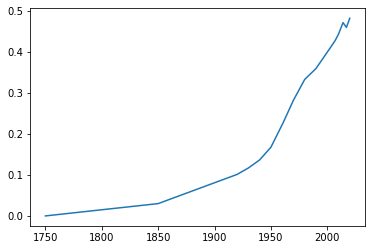

In [7]:
f = interp1d(skeie_ssp245.index, skeie_ssp245, bounds_error=False, fill_value='extrapolate')
years = np.arange(1750,2021)
o3total = f(years)
pl.plot(years, o3total)
print("2014-1750 ozone ERF from Skeie:", o3total[264])
print("2019-1750 ozone ERF from Skeie:", o3total[269])

In [8]:
df = pd.DataFrame(o3total, columns=['o3_erf'], index=np.arange(1750,2021))
df.index.name = 'year'
df.to_csv('../data_output/o3_erf.csv')

## Tuning to emissions for projections: NO TEMPERATURE FEEDBACK

Thornhill et al (2020) contributions to 2014-1850 ozone forcing: 

|species  | best  | unc    |
|---------|-------|--------|
|CH4      | +0.14 | (0.05) |
|NOx      | +0.20 | (0.11) |
|CO + VOC | +0.11 | (0.07) |
|N2O      | +0.03 | (0.02) |
|ODS      | -0.11 | (0.10) |  
|Sum      | +0.37 | (0.18) |

Uncertainties, in brackets, taken to be 5-95%.

Here we will define ODS as the Velders EESC definition.

In [9]:
emissions = pd.read_csv('../data_input_large/rcmip-emissions-annual-means-v5-1-0.csv')
concentrations = pd.read_csv('../data_input_large/rcmip-concentrations-annual-means-v5-1-0.csv')

scenario = 'ssp245'
ch4 = concentrations.loc[(concentrations['Scenario']==scenario)&(concentrations['Region']=='World')&(concentrations.Variable.str.endswith('|CH4')),'1750':'2020'].values.squeeze()
n2o = concentrations.loc[(concentrations['Scenario']==scenario)&(concentrations['Region']=='World')&(concentrations.Variable.str.endswith('|N2O')),'1750':'2020'].values.squeeze()
ods = {}
ods_species = [
    'CCl4',
    'CFC11',
    'CFC113',
    'CFC114',
    'CFC115',
    'CFC12',
    'CH2Cl2',
    'CH3Br',
    'CH3CCl3',
    'CH3Cl',
    'CHCl3',
    'HCFC141b',
    'HCFC142b',
    'HCFC22',
    'Halon1211',
    'Halon1301',
    'Halon2402',
]
for specie in ods_species:
    ods[specie] = concentrations.loc[(concentrations['Scenario']==scenario)&(concentrations['Region']=='World')&(concentrations.Variable.str.endswith('|%s' % specie)),'1750':'2020'].values.squeeze()

co  = emissions.loc[(emissions['Scenario']==scenario)&(emissions['Region']=='World')&(emissions.Variable.str.endswith('|CO')),'1750':'2020'].interpolate(axis=1).values.squeeze()
nox = emissions.loc[(emissions['Scenario']==scenario)&(emissions['Region']=='World')&(emissions.Variable.str.endswith('|NOx')),'1750':'2020'].interpolate(axis=1).values.squeeze()
voc = emissions.loc[(emissions['Scenario']==scenario)&(emissions['Region']=='World')&(emissions.Variable.str.endswith('|VOC')),'1750':'2020'].interpolate(axis=1).values.squeeze()

(271,)

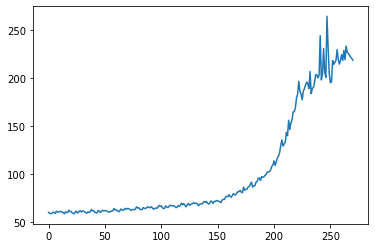

In [10]:
pl.plot(voc)
nox.shape

In [11]:
eesc_total = np.zeros((271))
for specie in ods_species:
    eesc_total = eesc_total + eesc(ods[specie], specie)

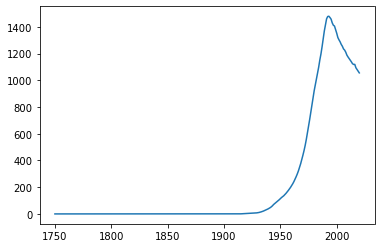

In [12]:
pl.plot(np.arange(1750,2021), eesc_total)

In [13]:
delta_Cch4 = ch4[264] - ch4[0]
delta_Cn2o = n2o[264] - n2o[0]
delta_Cods = eesc_total[264] - eesc_total[0]
delta_Eco  = co[264] - co[0]
delta_Evoc = voc[264] - voc[0]
delta_Enox = nox[264] - nox[0]

In [14]:
# best estimate radiative efficienices from 2014 - 1850

radeff_ch4 = 0.14/delta_Cch4
radeff_n2o = 0.03/delta_Cn2o
radeff_ods = -0.11/delta_Cods
radeff_co  = 0.067/delta_Eco    # stevenson rescaled
radeff_voc = 0.043/delta_Evoc   # stevenson rescaled
radeff_nox = 0.20/delta_Enox

In [15]:
fac_cmip6_skeie = (
    (
    radeff_ch4 * delta_Cch4 +
    radeff_n2o * delta_Cn2o +
    radeff_ods * delta_Cods +
    radeff_co  * delta_Eco +
    radeff_voc * delta_Evoc +
    radeff_nox * delta_Enox 
    ) / (o3total[264]-o3total[0])
)
ts = np.vstack((ch4, n2o, eesc_total, co, voc, nox)).T

In [16]:
ts

array([[ 731.40599569,  273.86505127,    0.        ,  348.52735878,
          60.02182622,   12.73521194],
       [ 731.83816528,  273.89405568,    0.        ,  343.92636725,
          59.08812628,   12.59230324],
       [ 732.89997355,  273.92705536,    0.        ,  341.8090339 ,
          58.63199703,   12.59427042],
       ...,
       [1887.04099528,  330.54097239, 1081.28293378,  903.25133099,
         222.21100855,  151.04965204],
       [1899.4105835 ,  331.30197652, 1068.45175863,  892.88514643,
         220.53307163,  149.55938605],
       [1910.97063192,  332.06797536, 1055.34645186,  882.51896187,
         218.85513471,  148.06912005]])

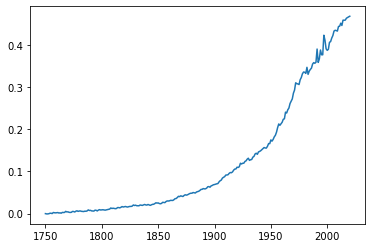

In [17]:
def fit_precursors(x, rch4, rn2o, rods, rco, rvoc, rnox):
    return rch4*x[0] + rn2o*x[1] + rods*x[2] + rco*x[3] + rvoc*x[4] + rnox*x[5]

p, cov = curve_fit(
    fit_precursors, 
    ts[:271,:].T - ts[0:1, :].T,
    o3total[:271]-o3total[0],
    bounds=(
        (
            0.09/delta_Cch4/fac_cmip6_skeie,
            0.01/delta_Cn2o/fac_cmip6_skeie,
            -0.21/delta_Cods/fac_cmip6_skeie,
            0.010/delta_Eco/fac_cmip6_skeie,
            0/delta_Evoc/fac_cmip6_skeie,
            0.09/delta_Enox/fac_cmip6_skeie
        ), (
            0.19/delta_Cch4/fac_cmip6_skeie, 
            0.05/delta_Cn2o/fac_cmip6_skeie, 
            -0.01/delta_Cods/fac_cmip6_skeie, 
            0.124/delta_Eco/fac_cmip6_skeie, 
            0.086/delta_Evoc/fac_cmip6_skeie, 
            0.31/delta_Enox/fac_cmip6_skeie
        )
    )
)

forcing = (
    p[0] * (ch4 - ch4[0]) +
    p[1] * (n2o - n2o[0]) +
    p[2] * (eesc_total - eesc_total[0]) +
    p[3] * (co  - co[0]) +
    p[4] * (voc  - voc[0]) +
    p[5] * (nox  - nox[0])
)

pl.plot(np.arange(1750,2021), forcing)

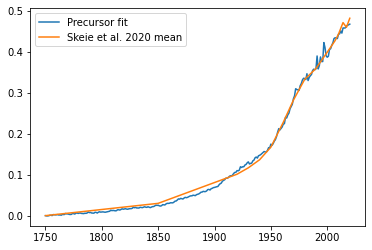

In [18]:
pl.plot(np.arange(1750,2021), forcing, label='Precursor fit')
pl.plot(np.arange(1750,2021), o3total, label='Skeie et al. 2020 mean')
pl.legend()

In [19]:
print(p)  # these coefficients we export to the ERF time series
print(radeff_ch4, radeff_n2o, radeff_ods, radeff_co, radeff_voc, radeff_nox)

[ 2.19988638e-04  1.19881702e-03 -6.74329740e-05  1.39653575e-04
  5.40764819e-17  9.95704497e-04]
0.00012726520677350334 0.0005647277798283193 -9.787056469289512e-05 0.00010885100689986857 0.0002478333432476061 0.0013995310245784151


## Tuning to emissions for projections: INCLUDING TEMPERATURE FEEDBACK

Skeie et al. 2020 analyses CMIP6 historical coupled models, so it should include a temperature feedback on total ozone forcing for all models except Oslo-CTM3.

1. Get observed 1850-2014 warming from AR6 (use 1850-1900 to 2009-19)
2. Calculate temperature-ozone feedback at -0.064 W/m2/K
3. Subtract this feedback from all model results except Oslo-CTM3, which was run with fixed-SST, and take average of the forcing
4. recalibrate Thornhill coefficients
5. grab a beer, you deserve it

In [20]:
xl = pd.read_excel('../data_input/observations/Consolidated GMST time series.xlsx', skiprows=8, skipfooter=9)
Tobs=xl['5-set mean'][:-1].values
years=xl['Unnamed: 0'][:-1].values

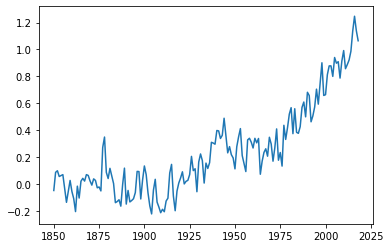

In [21]:
pl.plot(years, Tobs)

In [22]:
Tobs[:51].mean()  # already normalised to 1850-1900 anyway - from plot above, looks stable

-1.5782582212808597e-17

In [23]:
Tobs[159:170].mean()

1.014904397254902

In [24]:
delta_gmst = pd.DataFrame(
{
    1850: 0,
    1920: Tobs[65:76].mean(),
    1930: Tobs[75:86].mean(),
    1940: Tobs[85:96].mean(),
    1950: Tobs[95:106].mean(),
    1960: Tobs[105:116].mean(),
    1970: Tobs[115:126].mean(),
    1980: Tobs[125:136].mean(),
    1990: Tobs[135:146].mean(),
    2000: Tobs[145:156].mean(),
    2007: Tobs[152:163].mean(),
    2010: Tobs[155:166].mean(),
    2014: Tobs[159:170].mean(),
    2017: Tobs[167],   # we don't use this
    2020: Tobs[168]    # or this
}, index=[0])
delta_gmst

delta_gmst=[
    0,
    Tobs[65:76].mean(),
    Tobs[75:86].mean(),
    Tobs[85:96].mean(),
    Tobs[95:106].mean(),
    Tobs[105:116].mean(),
    Tobs[115:126].mean(),
    Tobs[125:136].mean(),
    Tobs[135:146].mean(),
    Tobs[145:156].mean(),
    Tobs[152:163].mean(),
    Tobs[155:166].mean(),
    Tobs[159:170].mean(),
    Tobs[167],   # we don't use this
    Tobs[168]
]
delta_gmst

[0,
 0.007445391800356482,
 0.11655357361853831,
 0.32178090089126554,
 0.2557969008912656,
 0.248112337254902,
 0.2533307554367201,
 0.3948969918003565,
 0.5520722463458111,
 0.7805853190730837,
 0.8859149190730838,
 0.9303829008912655,
 1.014904397254902,
 1.139188137254902,
 1.064936137254902]

In [25]:
warming_pi_pd = Tobs[159:170].mean()

In [26]:
skeie_trop = pd.read_csv('../data_input/Skeie_et_al_npj_2020/skeie_ozone_trop.csv', index_col=0)
skeie_trop = skeie_trop.loc[good_models]
skeie_trop.insert(0, 1850, 0)
skeie_trop.columns = pd.to_numeric(skeie_trop.columns)
skeie_trop.interpolate(axis=1, method='values', limit_area='inside', inplace=True)
skeie_strat = pd.read_csv('../data_input/Skeie_et_al_npj_2020/skeie_ozone_strat.csv', index_col=0)
skeie_strat = skeie_strat.loc[good_models]
skeie_strat.insert(0, 1850, 0)
skeie_strat.columns = pd.to_numeric(skeie_strat.columns)
skeie_strat.interpolate(axis=1, method='values', limit_area='inside', inplace=True)
skeie_total = skeie_strat + skeie_trop
skeie_total
coupled_models = copy.deepcopy(good_models)
coupled_models.remove('OsloCTM3')
skeie_total.loc[coupled_models] = skeie_total.loc[coupled_models] - (-0.037) * np.array(delta_gmst)
skeie_ssp245 = skeie_total.mean()
skeie_ssp245[1750] = -0.03
skeie_ssp245.sort_index(inplace=True)
skeie_ssp245 = skeie_ssp245 + 0.03
skeie_ssp245.drop([2014,2017,2020], inplace=True)
skeie_ssp245 = skeie_ssp245.append(skeie_total.loc['OsloCTM3',2014:]-skeie_total.loc['OsloCTM3',2010]+skeie_ssp245[2010])
skeie_ssp245   # this is what the ozone forcing would be, in the absence of any feedbacks

1750    0.000000
1850    0.030000
1920    0.101361
1930    0.120370
1940    0.146343
1950    0.175137
1960    0.229450
1970    0.289761
1980    0.344843
1990    0.376272
2000    0.422835
2007    0.454682
2010    0.471753
2014    0.499953
2017    0.488353
2020    0.510553
dtype: float64

2014-1750 ozone ERF from Skeie: 0.4999534727774807
2019-1750 ozone ERF from Skeie: 0.5031534727774808
2014-1850 ozone ERF from Skeie: 0.4699534727774807


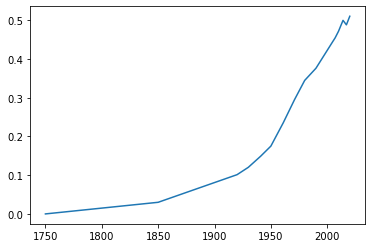

In [27]:
f = interp1d(skeie_ssp245.index, skeie_ssp245, bounds_error=False, fill_value='extrapolate')
years = np.arange(1750,2021)
o3total = f(years)
pl.plot(years, o3total)
print("2014-1750 ozone ERF from Skeie:", o3total[264])
print("2019-1750 ozone ERF from Skeie:", o3total[269])
print("2014-1850 ozone ERF from Skeie:", o3total[264] - o3total[100])

In [28]:
# best estimate radiative efficienices from 2014 - 1850

radeff_ch4 = 0.14/delta_Cch4
radeff_n2o = 0.03/delta_Cn2o
radeff_ods = -0.11/delta_Cods
radeff_co  = 0.067/delta_Eco    # stevenson rescaled
radeff_voc = 0.043/delta_Evoc   # stevenson rescaled
radeff_nox = 0.20/delta_Enox

In [29]:
fac_cmip6_skeie = (
    (
    radeff_ch4 * delta_Cch4 +
    radeff_n2o * delta_Cn2o +
    radeff_ods * delta_Cods +
    radeff_co  * delta_Eco +
    radeff_voc * delta_Evoc +
    radeff_nox * delta_Enox 
    ) / (o3total[264]-o3total[0])
)
ts = np.vstack((ch4, n2o, eesc_total, co, voc, nox)).T

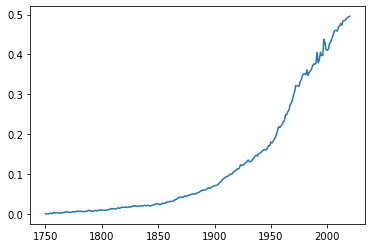

In [30]:
def fit_precursors(x, rch4, rn2o, rods, rco, rvoc, rnox):
    return rch4*x[0] + rn2o*x[1] + rods*x[2] + rco*x[3] + rvoc*x[4] + rnox*x[5]

p, cov = curve_fit(
    fit_precursors, 
    ts[:271,:].T - ts[0:1, :].T,
    o3total[:271]-o3total[0],
    bounds=(
        (
            0.09/delta_Cch4/fac_cmip6_skeie,
            0.01/delta_Cn2o/fac_cmip6_skeie,
            -0.21/delta_Cods/fac_cmip6_skeie,
            0.010/delta_Eco/fac_cmip6_skeie,
            0/delta_Evoc/fac_cmip6_skeie,
            0.09/delta_Enox/fac_cmip6_skeie
        ), (
            0.19/delta_Cch4/fac_cmip6_skeie, 
            0.05/delta_Cn2o/fac_cmip6_skeie, 
            -0.01/delta_Cods/fac_cmip6_skeie, 
            0.124/delta_Eco/fac_cmip6_skeie, 
            0.086/delta_Evoc/fac_cmip6_skeie, 
            0.31/delta_Enox/fac_cmip6_skeie
        )
    )
)

forcing = (
    p[0] * (ch4 - ch4[0]) +
    p[1] * (n2o - n2o[0]) +
    p[2] * (eesc_total - eesc_total[0]) +
    p[3] * (co  - co[0]) +
    p[4] * (voc  - voc[0]) +
    p[5] * (nox  - nox[0])
)

pl.plot(np.arange(1750,2021), forcing)

In [31]:
o3_aerchemmip = (
    radeff_ch4 * (ch4 - ch4[0]) +
    radeff_n2o * (n2o - n2o[0]) +
    radeff_ods * (eesc_total - eesc_total[0]) +
    radeff_co * (co - co[0]) +
    radeff_voc * (voc - voc[0]) +
    radeff_nox * (nox - nox[0])
)

In [32]:
delta_Cch4_1850 = ch4[264] - ch4[100]
delta_Cn2o_1850 = n2o[264] - n2o[100]
delta_Cods_1850 = eesc_total[264] - eesc_total[100]
delta_Eco_1850  = co[264] - co[100]
delta_Evoc_1850 = voc[264] - voc[100]
delta_Enox_1850 = nox[264] - nox[100]

radeff_ch4_1850 = 0.14/delta_Cch4_1850
radeff_n2o_1850 = 0.03/delta_Cn2o_1850
radeff_ods_1850 = -0.11/delta_Cods_1850
radeff_co_1850  = 0.067/delta_Eco_1850    # stevenson rescaled
radeff_voc_1850 = 0.043/delta_Evoc_1850   # stevenson rescaled
radeff_nox_1850 = 0.20/delta_Enox_1850

o3_aerchemmip = (
    radeff_ch4_1850 * (ch4 - ch4[0]) +
    radeff_n2o_1850 * (n2o - n2o[0]) +
    radeff_ods_1850 * (eesc_total - eesc_total[0]) +
    radeff_co_1850 * (co - co[0]) +
    radeff_voc_1850 * (voc - voc[0]) +
    radeff_nox_1850 * (nox - nox[0])
)

1


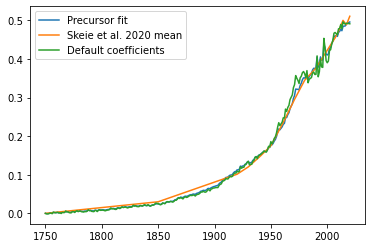

In [33]:
# scale everything up to be exactly equal in 2014
#ratio = forcing[170]/(o3total[270]-o3total[100])
ratio=1
print(ratio)
pl.plot(np.arange(1750,2021), forcing/ratio, label='Precursor fit')
pl.plot(np.arange(1750,2021), o3total, label='Skeie et al. 2020 mean')
pl.plot(np.arange(1750,2021), 47/37*o3_aerchemmip, label='Default coefficients')
#pl.xlim(2000,2020)
#pl.ylim(0.4,0.5)
pl.legend()

## these are the coefficients to use (first line)

In [34]:
p  # these coefficients we export to the ERF time series
#print(radeff_ch4/ratio, radeff_n2o/ratio, radeff_ods/ratio, radeff_co/ratio, radeff_voc/ratio, radeff_nox/ratio)
unc = np.array([47/37*radeff_ch4_1850*5/14, 47/37*radeff_n2o_1850*2/3, 47/37*radeff_ods_1850*10/11, 47/37*radeff_co_1850*57/67, 47/37*radeff_voc_1850*43/43, 47/37*radeff_nox_1850*11/20])

df = pd.DataFrame(data={'mean': p, 'u90': unc})
df.index = ['CH4','N2O','ODS','CO','NMVOC','NO2']
df.index.name='species'
df.to_csv('../data_input/tunings/cmip6_ozone_skeie_fits.csv')
df
#pl.savetxt('../data_input/ozone_coeffici')

,mean,u90
species,,
CH4,2.333797e-04,0.000062
N2O,1.271791e-03,0.000471
ODS,-6.693478e-05,-0.000113
CO,1.146477e-04,0.000131
NMVOC,5.143661e-12,0.000328
NO2,1.151513e-03,0.000983


In [35]:
print(p[0] * (ch4[264] - ch4[100]))
print(p[1] * (n2o[264] - n2o[100]))
print(p[2] * (eesc_total[264] - eesc_total[100]))
print(p[3] * (co[264]  - co[100]))
print(p[4] * (voc[264]  - voc[100]))
print(p[5] * (nox[264]  - nox[100]))

0.2387992568145111
0.06863467724277114
-0.07523023947626467
0.06335257031324791
8.576666550992534e-10
0.16372638479548873


In [36]:
print(radeff_ch4 * (ch4[264] - ch4[100]))
print(radeff_n2o * (n2o[264] - n2o[100]))
print(radeff_ods * (eesc_total[264] - eesc_total[100]))
print(radeff_co * (co[264]  - co[100]))
print(radeff_voc * (voc[264]  - voc[100]))
print(radeff_nox * (nox[264]  - nox[100]))

0.13022055553690706
0.03047663268193132
-0.11
0.06014940576347769
0.04132434361690338
0.19899042743553352


In [37]:
47/37*radeff_ch4_1850, 47/37*radeff_n2o_1850, 47/37*radeff_ods_1850, 47/37*radeff_co_1850, 47/37*radeff_voc_1850, 47/37*radeff_nox_1850

(0.00017380181731885394,
 0.0007061379618263551,
 -0.00012432206866394785,
 0.00015401820093350843,
 0.00032758074092083077,
 0.0017868021851642044)

In [38]:
47/37*radeff_ch4_1850*5/14, 47/37*radeff_n2o_1850*2/3, 47/37*radeff_ods_1850*10/11, 47/37*radeff_co_1850*57/67, 47/37*radeff_voc_1850*43/43, 47/37*radeff_nox_1850*11/20

(6.207207761387641e-05,
 0.0004707586412175701,
 -0.00011302006242177078,
 0.00013103040974940267,
 0.00032758074092083077,
 0.0009827412018403123)